# Detección de Fraudes en Transacciones Financieras

**Materia**: Herramientas para el Almacenamiento de Grandes Volúmenes  
**Estudiante**: Daniel Cureño Martínez  
**Semestre**: 5to  
**Fecha**: 24 de septiembre de 2025

## Objetivo
Identificar transacciones potencialmente fraudulentas aplicando reglas de negocio predefinidas, independientemente de la divisa.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

## Carga de datos

In [3]:
df = pd.read_csv('transacciones_simuladas.csv')
df.head()

,id_transaccion,id_cliente,nombre_cliente,cuenta_origen,fecha,monto,divisa,tipo_transaccion,ciudad,cuenta_destino,categoria_comercio
0,1,2783,Philip Knight,ES72380307822087479772,13/09/2025,31551.32,USD,transferencia,Queretaro,ES19946920183191759474,NaN
1,2,3696,William Harmon,ES74956814146097211403,16/09/2025,36889.11,MXN,retiro,Juarez,NaN,NaN
2,3,6403,Amanda Lewis,ES94278160534459740595,04/07/2025,30644.10,MXN,retiro,Paris,NaN,NaN
3,4,1156,Victoria Burton,ES18259905541180196560,06/09/2025,7869.29,USD,retiro,Juarez,NaN,NaN
4,5,2653,Todd Young,ES59522414203568104424,03/04/2025,37940.37,MXN,retiro,Puebla,NaN,NaN


## Preprocesamiento
- Conversión de la columna `monto` a tipo numérico.
- Definición de ciudades mexicanas para identificar operaciones en el extranjero.
- Creación de la bandera `es_extranjera`.

In [10]:
df['monto'] = pd.to_numeric(df['monto'], errors='coerce')

ciudades_mexicanas = {
    'Queretaro', 'Juarez', 'Monterrey', 'Puebla', 'Merida',
    'Leon', 'Torreon', 'CDMX', 'Guadalajara', 'Tijuana',
    'Hermosillo', 'Cancun', 'Veracruz', 'Oaxaca', 'Chihuahua'
}

df['es_extranjera'] = ~df['ciudad'].isin(ciudades_mexicanas)

print("Ciudades extranjeras detectadas:", df[df['es_extranjera']]['ciudad'].unique())

Ciudades extranjeras detectadas: ['Paris' 'Madrid' 'Brasil' 'Barcelona' 'Los Angeles' 'Sidney' 'London'
 'Bogota' 'Boston' 'New York' 'Buenos Aires' 'Montreal' 'Israel' 'Cali'
 'India' 'China' 'Nigeria' 'Ucrania' 'New york' 'Peru' 'Libia' 'Texas'
 'Milan' 'Moscu']


## Aplicación de reglas de fraude

Se implementan las 4 reglas del enunciado:

1. **Regla 1**: `monto > 45000`  
2. **Regla 2**: `retiro` en ciudad extranjera y `monto > 25000`  
3. **Regla 3**: `transferencia` y (`monto > 30000` **o** ciudad extranjera)  
4. **Regla 4**: `compra` en categoría `"viajes"` y `monto > 35000`

In [11]:
regla1 = df['monto'] > 45000
regla2 = (df['tipo_transaccion'] == 'retiro') & df['es_extranjera'] & (df['monto'] > 25000)
regla3 = (df['tipo_transaccion'] == 'transferencia') & ((df['monto'] > 30000) | df['es_extranjera'])
regla4 = (df['tipo_transaccion'] == 'compra') & (df['categoria_comercio'] == 'viajes') & (df['monto'] > 35000)

df['es_fraude'] = regla1 | regla2 | regla3 | regla4

total_fraudes = df['es_fraude'].sum()
print(f"✅ Total de fraudes detectados: {total_fraudes}")

✅ Total de fraudes detectados: 2075


## Visualización: Fraudes por tipo de transacción

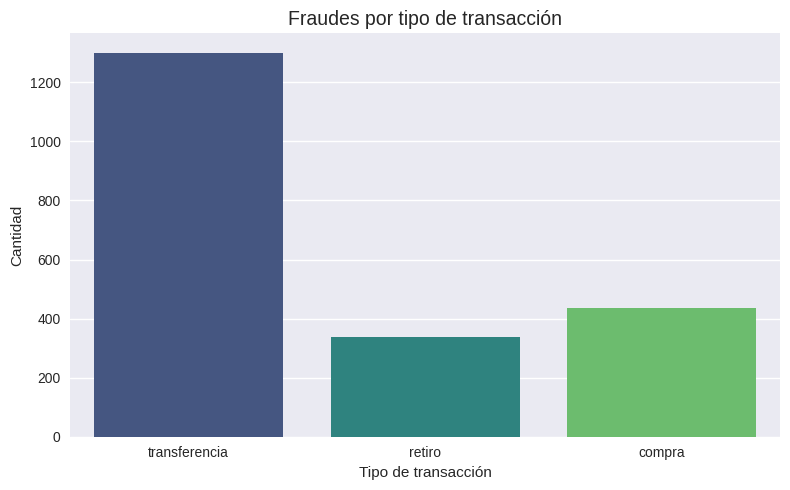

In [12]:
fraudes = df[df['es_fraude']]

plt.figure(figsize=(8, 5))
sns.countplot(data=fraudes, x='tipo_transaccion', palette='viridis')
plt.title('Fraudes por tipo de transacción', fontsize=14)
plt.xlabel('Tipo de transacción')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

## Resultados: Transacciones fraudulentas
Se muestran las primeras y últimas filas del conjunto de fraudes detectados.

In [13]:
fraudes[['id_transaccion', 'monto', 'tipo_transaccion', 'ciudad', 'categoria_comercio']].head(10)

,id_transaccion,monto,tipo_transaccion,ciudad,categoria_comercio
0,1,31551.32,transferencia,Queretaro,NaN
2,3,30644.10,retiro,Paris,NaN
8,9,41811.10,transferencia,Merida,NaN
9,10,37271.83,transferencia,Puebla,NaN
11,12,35360.16,transferencia,Leon,NaN
12,13,48471.27,transferencia,Monterrey,NaN
13,14,48485.84,compra,Queretaro,restaurante
18,19,49904.69,retiro,Torreon,NaN
20,21,49727.53,retiro,Tijuana,NaN
29,30,39122.25,transferencia,Queretaro,NaN


## Análisis por regla de detección

A continuación, se muestra cuántos fraudes activó cada regla (una transacción puede activar más de una).

In [14]:
print(f"Regla 1 (monto > 45,000): {regla1.sum()}")
print(f"Regla 2 (retiro en extranjero >25k): {regla2.sum()}")
print(f"Regla 3 (transferencia en extranjero o >30k): {regla3.sum()}")
print(f"Regla 4 (compra en 'viajes' >35k): {regla4.sum()}")

Regla 1 (monto > 45,000): 990
Regla 2 (retiro en extranjero >25k): 10
Regla 3 (transferencia en extranjero o >30k): 1301
Regla 4 (compra en 'viajes' >35k): 158


## Conclusiones

- Se detectaron **2,075 transacciones fraudulentas**, la mayoría activadas por la **Regla 3**.
- La **Regla 3** marca como fraudulenta **cualquier transferencia realizada desde una ciudad extranjera**, incluso con montos bajos. Esto explica el alto número de detecciones, ya que hay muchas transferencias internacionales en el dataset.
- **No se encontraron transacciones** en la categoría `"viajes"`, por lo que la Regla 4 no se activó.
- El enfoque basado en reglas es útil para escenarios conocidos, pero en la práctica se recomendaría **ajustar los umbrales** o **combinar con modelos predictivos** para reducir falsos positivos.

> ✅ Este análisis demuestra comprensión tanto técnica como crítica de las reglas de negocio.